### Creating and running a simple quantum program

In [2]:
# Imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

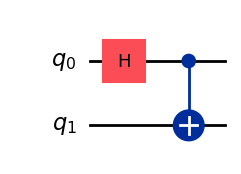

In [3]:
# Generating new circuits
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

In [4]:
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

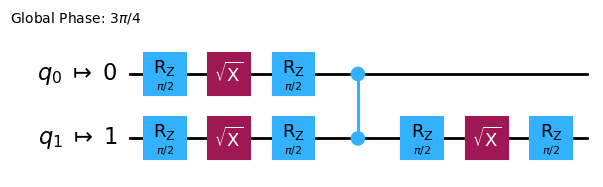

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# Convert to ISA circuit and layout-mapped observables
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

In [6]:
# Estimator instance
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d4u5hqfg0u6s73d9crgg


In [7]:
# examining job output
job_result = job.result()

pub_result = job.result()[0]

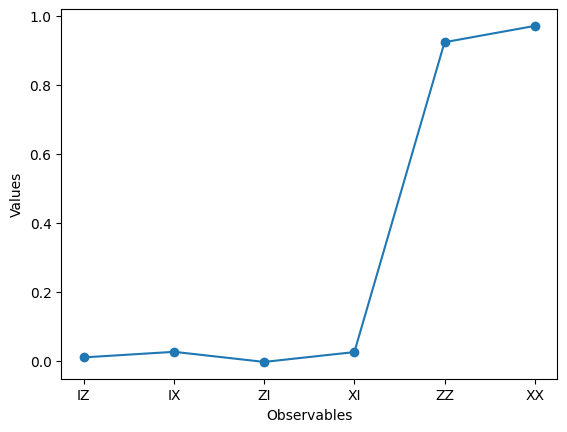

In [8]:
from matplotlib import pyplot as plt 

values = pub_result.data.evs
errors = pub_result.data.stds

plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

### Scaling to large numbers of qubits

In [11]:
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)

        for i in range(n- 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not valid input")
    return qc

n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

In [12]:
# Mapping to operators of interest
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]

print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [16]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

In [17]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

In [19]:
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

d4u6507g0u6s73d9dfd0


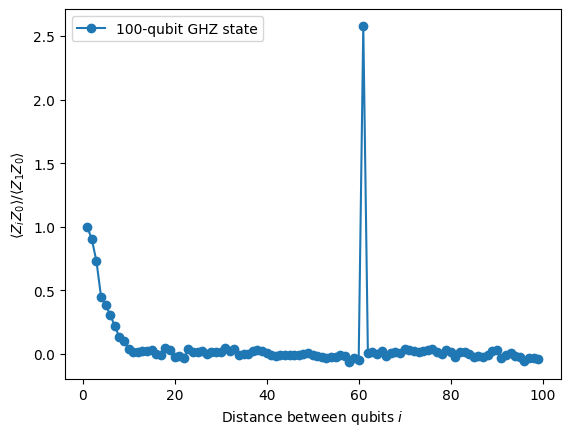

In [20]:
# Post process results
data = list(range(1, len(operators) + 1))
result = job.result()[0]
values = result.data.evs
values = [
    v / values[0] for v in values
]

plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()